# Siamese Network - Question duplicate

Objective: 

Dataset: Quora Question pairs https://www.kaggle.com/c/quora-question-pairs/

Notes : 
- SNNs won’t output the probabilities of the prediction, only distance from each class.
- Since training SNNs involve pairwise learning, we cannot use cross entropy loss cannot be used. There are two loss functions we typically use to train siamese networks: triplet loss and contrastive loss

## Install trax

In [1]:
!pip install -q -U trax
import trax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 637.9/637.9 KB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 52.8 MB/s eta 0:00:00


In [46]:
import os
import nltk
import trax
from trax import layers as tl
from trax.supervised import training
from trax.fastmath import numpy as fastnp
import numpy as np
import pandas as pd
import random as rnd
from trax import shapes

# set random seeds
RANDOM_SEED=42
rnd.seed(34)

# We need to download the punkt data to be able to tokenize our sentences.
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Dataset

In [4]:
data = pd.read_csv("train.csv")
N=len(data)
print('Number of question pairs: ', N)
data.head()

Number of question pairs:  404290


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


Divide between train/test set

In [5]:
N_train = 300000
N_test  = 10*1024
data_train = data[:N_train]
data_test  = data[N_train:N_train+N_test]
print("Train set:", len(data_train), "Test set:", len(data_test))
del(data) # remove to free memory

Train set: 300000 Test set: 10240


Filtering out non-duplicates. Two batches Q1 and Q2 are built. 
-  q1i == q2i  
-  q1i =/= q2j if i=/=j  

In [6]:
td_index = (data_train['is_duplicate'] == 1).to_numpy()
td_index = [i for i, x in enumerate(td_index) if x] 
print('number of duplicate questions: ', len(td_index))
print('indexes of first ten duplicate questions:', td_index[:10])

number of duplicate questions:  111473
indexes of first ten duplicate questions: [5, 7, 11, 12, 13, 15, 16, 18, 20, 29]


One example of duplicate

In [7]:
print(data_train['question1'][7])  
print(data_train['question2'][7])
print('is_duplicate: ', data_train['is_duplicate'][7])

How can I be a good geologist?
What should I do to be a great geologist?
is_duplicate:  1


Training and test dataset. the training dataset only contains duplicates

In [8]:
Q1_train_words = np.array(data_train['question1'][td_index])
Q2_train_words = np.array(data_train['question2'][td_index])

Q1_test_words = np.array(data_test['question1'])
Q2_test_words = np.array(data_test['question2'])
y_test  = np.array(data_test['is_duplicate'])

Example

In [9]:
print('TRAINING QUESTIONS:\n')
print('Question 1: ', Q1_train_words[0])
print('Question 2: ', Q2_train_words[0], '\n')
print('Question 1: ', Q1_train_words[5])
print('Question 2: ', Q2_train_words[5], '\n')

print('TESTING QUESTIONS:\n')
print('Question 1: ', Q1_test_words[0])
print('Question 2: ', Q2_test_words[0], '\n')
print('is_duplicate =', y_test[0], '\n')

TRAINING QUESTIONS:

Question 1:  Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
Question 2:  I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me? 

Question 1:  What would a Trump presidency mean for current international master’s students on an F1 visa?
Question 2:  How will a Trump presidency affect the students presently in US or planning to study in US? 

TESTING QUESTIONS:

Question 1:  What were some of the troubles you have faced during and after your 9 months period of pregnancy?
Question 2:  What is the difference between neural circuit and neural system? 

is_duplicate = 0 



## Encoding

### Build the vocabulary

We build the vocabulary by mapping the words to the "index" for that word in the dictionary. For all out Out of Vocabulary words, the index 0 is assigned.
Questions are encoded as q list of numbers.
Pad value at 1

In [10]:
#create arrays
Q1_train = np.empty_like(Q1_train_words)
Q2_train = np.empty_like(Q2_train_words)

Q1_test = np.empty_like(Q1_test_words)
Q2_test = np.empty_like(Q2_test_words)

In [11]:
from collections import defaultdict

vocab = defaultdict(lambda: 0)
vocab['<PAD>'] = 1

for idx in range(len(Q1_train_words)):
    Q1_train[idx] = nltk.word_tokenize(Q1_train_words[idx])
    Q2_train[idx] = nltk.word_tokenize(Q2_train_words[idx])
    q = Q1_train[idx] + Q2_train[idx]
    for word in q:
        if word not in vocab:
            vocab[word] = len(vocab) + 1
print('The length of the vocabulary is: ', len(vocab))

The length of the vocabulary is:  36279


In [12]:
print(vocab['<PAD>'])
print(vocab['geology'])
print(vocab['history'])

1
8645
1774


In [13]:
for idx in range(len(Q1_test_words)): 
    Q1_test[idx] = nltk.word_tokenize(Q1_test_words[idx])
    Q2_test[idx] = nltk.word_tokenize(Q2_test_words[idx])

In [14]:
print('Train set has reduced to: ', len(Q1_train) ) 
print('Test set length: ', len(Q1_test) ) 

Train set has reduced to:  111473
Test set length:  10240


### Convering question to tensor

In [15]:
# Converting questions to array of integers
for i in range(len(Q1_train)):
    Q1_train[i] = [vocab[word] for word in Q1_train[i]]
    Q2_train[i] = [vocab[word] for word in Q2_train[i]]

        
for i in range(len(Q1_test)):
    Q1_test[i] = [vocab[word] for word in Q1_test[i]]
    Q2_test[i] = [vocab[word] for word in Q2_test[i]]

In [16]:
print('first question in the train set:\n')
print(Q1_train_words[0], '\n') 
print('encoded version:')
print(Q1_train[0],'\n')

print('first question in the test set:\n')
print(Q1_test_words[0], '\n')
print('encoded version:')
print(Q1_test[0]) 

first question in the train set:

Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me? 

encoded version:
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21] 

first question in the test set:

What were some of the troubles you have faced during and after your 9 months period of pregnancy? 

encoded version:
[30, 271, 116, 131, 78, 28828, 53, 218, 6589, 124, 11, 267, 56, 1636, 606, 2092, 131, 4329, 21]


### Validation set

In [18]:
# Splitting the data
TRAINING_FRACTION = 0.8

cut_off = int(len(Q1_train)*TRAINING_FRACTION)
train_Q1, train_Q2 = Q1_train[:cut_off], Q2_train[:cut_off]
val_Q1, val_Q2 = Q1_train[cut_off: ], Q2_train[cut_off:]
print('Number of duplicate questions: ', len(Q1_train))
print("The length of the training set is:  ", len(train_Q1))
print("The length of the validation set is: ", len(val_Q1))

Number of duplicate questions:  111473
The length of the training set is:   89178
The length of the validation set is:  22295


### Data generator

In [19]:
def data_generator(Q1, Q2, batch_size, pad=1, shuffle=True):
    """Generator function that yields batches of data

    Args:
        Q1 (list): List of transformed (to tensor) questions.
        Q2 (list): List of transformed (to tensor) questions.
        batch_size (int): Number of elements per batch.
        pad (int, optional): Pad character from the vocab. Defaults to 1.
        shuffle (bool, optional): If the batches should be randomnized or not. Defaults to True.
    Yields:
        tuple: Of the form (input1, input2) with types (numpy.ndarray, numpy.ndarray)
        NOTE: input1: inputs to your model [q1a, q2a, q3a, ...] i.e. (q1a,q1b) are duplicates
              input2: targets to your model [q1b, q2b,q3b, ...] i.e. (q1a,q2i) i!=a are not duplicates
    """

    input1 = []
    input2 = []
    idx = 0
    len_q = len(Q1)
    question_indexes = [*range(len_q)]
    
    if shuffle:
        rnd.shuffle(question_indexes)
    
    while True:
        if idx >= len_q:
            # if idx is greater than or equal to len_q, set idx accordingly 

            idx = 0
            # shuffle to get random batches if shuffle is set to True
            if shuffle:
                rnd.shuffle(question_indexes) 
        
        # get questions at the `question_indexes[idx]` position in Q1 and Q2
        q1 = Q1[question_indexes[idx]]
        q2 = Q2[question_indexes[idx]]

        idx += 1
        input1.append(q1)
        input2.append(q2)
        if len(input1) == batch_size:
            # determine max_len as the longest question in input1 & input 2
            max_len = max(max(len(x) for x in input1 ),max(len(x) for x in input2 ))
            max_len = 2**int(np.ceil(np.log2(max_len)))
            b1 = [] 
            b2 = [] 
            for q1, q2 in zip(input1, input2):
                # add [pad] to q1 until it reaches max_len
                q1 = q1 +[vocab['<PAD>']] * (max_len - len(q1))
                q2  = q2 +[vocab['<PAD>']] * (max_len - len(q2))                
                b1.append(q1)
                b2.append(q2)
            yield np.array(b1), np.array(b2)
            # reset the batches
            input1, input2 = [], []  

## Siamese network

Siamese network using pytorch from: https://github.com/JiHunWang/quora-question-similarity-kaggle/blob/main/model/siameseNetwork.py

In [20]:
def Siamese(vocab_size=41699, d_model=128, mode='train'):
    """Returns a Siamese model.

    Args:
        vocab_size (int, optional): Length of the vocabulary. Defaults to len(vocab).
        d_model (int, optional): Depth of the model. Defaults to 128.
        mode (str, optional): 'train', 'eval' or 'predict', predict mode is for fast inference. Defaults to 'train'.

    Returns:
        trax.layers.combinators.Parallel: A Siamese model. 
    """

    def normalize(x):  # normalizes the vectors to have L2 norm 1
        return x / fastnp.sqrt(fastnp.sum(x * x, axis=-1, keepdims=True))
    

    q_processor = tl.Serial( # Processor will run on Q1 and Q2. 
        tl.Embedding(vocab_size, d_model), # Embedding layer
        tl.LSTM(d_model), # LSTM layer
        tl.Mean(axis=1), # Mean over columns
        tl.Fn('Normalize', lambda x: normalize(x)), # Apply normalize function
    )  # Returns one vector of shape [batch_size, d_model]. 
    

    model = tl.Parallel(q_processor, q_processor)
    return model

In [38]:
model = Siamese()
print(model)

Parallel_in2_out2[
  Serial[
    Embedding_41699_128
    LSTM_128
    Mean
    Normalize
  ]
  Serial[
    Embedding_41699_128
    LSTM_128
    Mean
    Normalize
  ]
]


## Triplet loss

Triplet loss is composed of two terms. One term utilizes the mean of all the non duplicates, the second utilizes the *closest negative*. Our loss expression is then:
 
\begin{align}
 \mathcal{Loss_{1}(A,P,N)} &=\max \left( -cos(A,P)  + mean_{neg} +\alpha, 0\right) \\
 \mathcal{Loss_{2}(A,P,N)} &=\max \left( -cos(A,P)  + closest_{neg} +\alpha, 0\right) \\
\mathcal{Loss(A,P,N)} &= mean(Loss_1 + Loss_2) \\
\end{align}


In [39]:

def TripletLossFn(v1, v2, margin=0.25):
    """Custom Loss function.

    Args:
        v1 (numpy.ndarray): Array with dimension (batch_size, model_dimension) associated to Q1.
        v2 (numpy.ndarray): Array with dimension (batch_size, model_dimension) associated to Q2.
        margin (float, optional): Desired margin. Defaults to 0.25.

    Returns:
        jax.interpreters.xla.DeviceArray: Triplet Loss.
    """
    scores = fastnp.dot(v1, v2.T) # pairwise cosine sim  

    # calculate new batch size
    batch_size = len(scores)

    positive = fastnp.diagonal(scores)  # the positive ones (duplicates)
    negative_zero_on_duplicate = np.multiply(np.ones_like(scores) - fastnp.eye(batch_size),scores)
    mean_negative = fastnp.sum(negative_zero_on_duplicate,axis=1)/(batch_size - 1)
    mask_exclude_positives = (fastnp.identity(batch_size) == 1) | (negative_zero_on_duplicate > positive.reshape(batch_size,1))

    negative_without_positive = negative_zero_on_duplicate - mask_exclude_positives*2

    closest_negative = negative_without_positive.max(axis=1)
    triplet_loss1 = np.maximum(mean_negative - positive + margin, 0)
    triplet_loss2 = np.maximum(closest_negative - positive+ margin, 0)
    triplet_loss = fastnp.sum(triplet_loss1+triplet_loss2)  

    
    return triplet_loss

Test the triplet loss

In [40]:
v1 = np.array([[ 0.26726124,  0.53452248,  0.80178373],[-0.5178918 , -0.57543534, -0.63297887]])
v2 = np.array([[0.26726124, 0.53452248, 0.80178373],[0.5178918 , 0.57543534, 0.63297887]])
print("Triplet Loss:", TripletLossFn(v1,v2))

Triplet Loss: 0.7035077


Make a layer out of the triplet loss

In [41]:
from functools import partial
def TripletLoss(margin=0.25):
    triplet_loss_fn = partial(TripletLossFn, margin=margin)
    return tl.Fn('TripletLoss', triplet_loss_fn)

In [42]:
batch_size = 256
train_generator = data_generator(train_Q1, train_Q2, batch_size, vocab['<PAD>'])
val_generator = data_generator(val_Q1, val_Q2, batch_size, vocab['<PAD>'])
print('train_Q1.shape ', train_Q1.shape)
print('val_Q1.shape   ', val_Q1.shape)

train_Q1.shape  (89178,)
val_Q1.shape    (22295,)


In [43]:
def train_model(Siamese, TripletLoss
                , train_generator, val_generator, output_dir='model/'):
    """Training the Siamese Model

    Args:
        Siamese (function): Function that returns the Siamese model.
        TripletLoss (function): Function that defines the TripletLoss loss function.
        lr_schedule (function): Trax multifactor schedule function.
        train_generator (generator, optional): Training generator. Defaults to train_generator.
        val_generator (generator, optional): Validation generator. Defaults to val_generator.
        output_dir (str, optional): Path to save model to. Defaults to 'model/'.

    Returns:
        trax.supervised.training.Loop: Training loop for the model.
    """
    output_dir = os.path.expanduser(output_dir)

    train_task = training.TrainTask( 
        labeled_data=train_generator,      
        loss_layer=TripletLoss(),        
        optimizer=trax.optimizers.Adam(0.01),         
        lr_schedule=trax.lr.warmup_and_rsqrt_decay(400, 0.01) 
    )

    eval_task = training.EvalTask(
        labeled_data=val_generator,      
        metrics=[TripletLoss()],         
    )
    

    training_loop = training.Loop(Siamese(),
                                  train_task,
                                  eval_tasks=[eval_task],
                                  output_dir=output_dir)

    return training_loop

In [ ]:
train_steps = 5
training_loop = train_model(Siamese, TripletLoss, train_generator, val_generator)
training_loop.run(train_steps)

## Evaluation

In [49]:
model = Siamese()
model.init_from_file(file_name='model.pkl.gz', weights_only=True, input_signature=shapes.signature(next(train_generator)))

(((array([[-0.14566694,  0.0690302 ,  0.03528703, ...,  0.04289422,
            0.01495273,  0.0295836 ],
          [-0.18167959,  0.06158856, -0.02099077, ..., -0.37289554,
           -0.41506082, -0.47958568],
          [-0.08760101, -0.11774683,  0.10590506, ..., -0.12719558,
           -0.29383892, -0.8486252 ],
          ...,
          [ 0.11879876,  0.13377659,  0.0523452 , ...,  0.08617012,
           -0.14278218,  0.03775889],
          [ 0.03600347,  0.013896  , -0.12832586, ...,  0.08852937,
           -0.02288531,  0.10609501],
          [ 0.09160908,  0.0813653 ,  0.14018479, ...,  0.09997971,
            0.10666739, -0.10014597]], dtype=float32),
   (((), ((), ())),
    ((array([[-0.4249619 , -0.44568634,  0.09243102, ...,  0.24510421,
              -0.292594  ,  0.06616695],
             [-0.00212805,  0.39122954, -0.3265429 , ..., -0.01921497,
               0.17920703, -0.2882711 ],
             [ 0.26706126,  0.32310218, -0.1436266 , ...,  0.07792609,
              -0.

In [50]:
def classify(test_Q1, test_Q2, y, threshold, model, vocab, data_generator=data_generator, batch_size=64):
    """Function to test the accuracy of the model.

    Args:
        test_Q1 (numpy.ndarray): Array of Q1 questions.
        test_Q2 (numpy.ndarray): Array of Q2 questions.
        y (numpy.ndarray): Array of actual target.
        threshold (float): Desired threshold.
        model (trax.layers.combinators.Parallel): The Siamese model.
        vocab (collections.defaultdict): The vocabulary used.
        data_generator (function): Data generator function. Defaults to data_generator.
        batch_size (int, optional): Size of the batches. Defaults to 64.

    Returns:
        float: Accuracy of the model.
    """    
    
    
    accuracy = 0
    for i in range(0, len(test_Q1), batch_size):
        q1, q2 = next(data_generator(test_Q1[i:i + batch_size], test_Q2[i:i + batch_size], batch_size, vocab['<PAD>'], shuffle=False))
        y_test = y[i:i + batch_size]
        v1, v2 = model([q1,q2])

        for j in range(batch_size):

            d = np.dot(v1[j],v2[j])   
            res =  d > threshold  
            accuracy +=  (y_test[j] == res) 

    accuracy = accuracy  / len(test_Q1)
    
    return accuracy

In [51]:
accuracy = classify(Q1_test,Q2_test, y_test, 0.7, model, vocab, batch_size = 512) 
print("Accuracy", accuracy)

Accuracy 0.72646484375


## Evaluate

In [52]:
def predict(question1, question2, threshold, model, vocab, data_generator=data_generator, verbose=False):
    """Function for predicting if two questions are duplicates.

    Args:
        question1 (str): First question.
        question2 (str): Second question.
        threshold (float): Desired threshold.
        model (trax.layers.combinators.Parallel): The Siamese model.
        vocab (collections.defaultdict): The vocabulary used.
        data_generator (function): Data generator function. Defaults to data_generator.
        verbose (bool, optional): If the results should be printed out. Defaults to False.

    Returns:
        bool: True if the questions are duplicates, False otherwise.
    """
    q1 = nltk.word_tokenize(question1)  # tokenize
    q2 = nltk.word_tokenize(question2) # tokenize
    Q1, Q2 = [], []
    for word in q1: 
        Q1 += [vocab[word]]
    for word in q2:  # encode q2
        Q2 += [vocab[word]]
    
    Q1, Q2 = next(data_generator([Q1], [Q2], 1, vocab['<PAD>']))
    # Call the model
    v1, v2 = model([Q1, Q2])
    d =  np.dot(v1,v2.T)   
    res = d > threshold  

    
    if(verbose):
        print("Q1  = ", Q1, "\nQ2  = ", Q2)
        print("d   = ", d)
        print("res = ", res)

    return res

In [53]:
# Feel free to try with your own questions
question1 = "When will I see you?"
question2 = "When can I see you again?"
# 1/True means it is duplicated, 0/False otherwise
predict(question1 , question2, 0.7, model, vocab, verbose = True)

Q1  =  [[585  76   4  46  53  21   1   1]] 
Q2  =  [[ 585   33    4   46   53 7280   21    1]]
d   =  [[0.8585515]]
res =  [[ True]]


array([[ True]])

## Threshold variation

Distance evaluate using cosinus similarity, let's see how the threshold influence the accuracy

In [64]:
threshold = np.arange(0.1, 1, 0.1).tolist()
accuracy = []
for i in threshold:
  acc_t = classify(Q1_test,Q2_test, y_test, i , model, vocab, batch_size = 512) 
  accuracy.append(acc_t)
  print("Accuracy with a threshold of ",  str(i) ," is", str(acc_t))

print(accuracy)

Accuracy with a threshold of  0.1  is 0.45380859375
Accuracy with a threshold of  0.2  is 0.49912109375
Accuracy with a threshold of  0.30000000000000004  is 0.55146484375
Accuracy with a threshold of  0.4  is 0.6048828125
Accuracy with a threshold of  0.5  is 0.6595703125
Accuracy with a threshold of  0.6  is 0.7033203125
Accuracy with a threshold of  0.7000000000000001  is 0.72646484375
Accuracy with a threshold of  0.8  is 0.7197265625
Accuracy with a threshold of  0.9  is 0.67978515625
[0.45380859375, 0.49912109375, 0.55146484375, 0.6048828125, 0.6595703125, 0.7033203125, 0.72646484375, 0.7197265625, 0.67978515625]


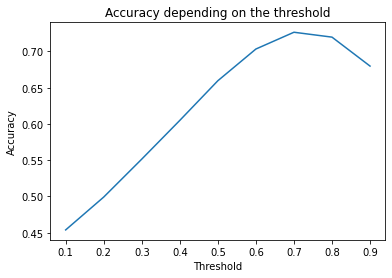

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(threshold, accuracy)
plt.title('Accuracy depending on the threshold')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.show()

In [61]:
accuracy

[0.45380859375, 0.49912109375]